# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

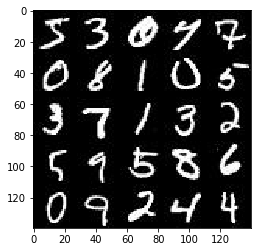

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

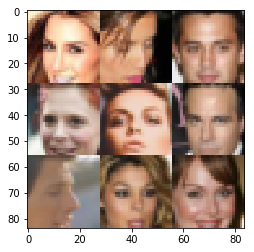

In [36]:
show_n_images = 9

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.10.0


C:\Users\Nadav Hacmun\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32, None)
    
    return real, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [23]:
def discriminator(images, reuse=False, training=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, (5,5), strides=(2,2), padding='same')
        x1 = tf.maximum(x1, alpha * x1)
        # batchx14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, (5,5), strides=(2,2), padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(x2, x2*alpha)
        # batchx7x7x128
        
        
        x3 = tf.layers.conv2d(x2, 256, (5,5), strides=(2,2), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(x3, alpha*x3)
        #batchx4x4x256
    
        flat = tf.layers.flatten(x3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [24]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # first FC layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        # reshaping 
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, (5,5), (2,2), padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, alpha*x2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, (5,5), (2,2), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, alpha*x3)
        # 28x28x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, (5,5), (1,1), padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim, training=False):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    out_z = generator(input_z, out_channel_dim)
    out_fake, logits_fake = discriminator(out_z, training=training)
    out_real, logits_real = discriminator(input_real, reuse=True, training=training)
    
    loss_d_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.zeros_like(logits_fake)))
    loss_d_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=tf.ones_like(logits_real)))
    loss_g = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=tf.ones_like(logits_fake)))
    
    loss_d = loss_d_fake + loss_d_real
    
    return loss_d, loss_g



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # getting the placeholders
    real_holder, z_holder, learning_rate_holder = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # getting model losses
    d_loss, g_loss = model_loss(real_holder, z_holder, data_shape[3], training=True)
    
    # getting optmizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_holder, beta1)
    
    # variable to count steps so we can print generator ouput
    steps = 0
    
    # defining the saver
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                # generating input for generator
                z = np.random.uniform(-1, 1, (data_shape[3], z_dim))
            
                # running the discriminator optimizer   
                _ = sess.run(d_opt, feed_dict={real_holder:batch_images,
                                           z_holder:z,
                                           learning_rate_holder:learning_rate})
                
                # running the generator optimizer        
                for i in range(3):    
                    _ = sess.run(g_opt, feed_dict={real_holder:batch_images,
                                           z_holder:z,
                                           learning_rate_holder:learning_rate})
        
                if steps % 15 == 0:
                    loss_d = sess.run(d_loss, feed_dict={real_holder:batch_images, z_holder:z})
                    loss_g = sess.run(g_loss, feed_dict={real_holder:batch_images, z_holder:z})
                    print('epoch: {}/{}, discriminator loss: {}, generator loss: {}'.format(epoch_i+1, epoch_count, loss_d, loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 9, z_holder, data_shape[3], data_image_mode)
        saver.save(sess, './checkpoint.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

epoch: 1/2, discriminator loss: 4.302835941314697, generator loss: 0.014269205741584301
epoch: 1/2, discriminator loss: 4.334221363067627, generator loss: 0.01335822232067585
epoch: 1/2, discriminator loss: 7.478445529937744, generator loss: 0.001053209649398923
epoch: 1/2, discriminator loss: 5.575943946838379, generator loss: 0.004036918748170137
epoch: 1/2, discriminator loss: 5.49042272567749, generator loss: 0.01670624129474163
epoch: 1/2, discriminator loss: 3.7906782627105713, generator loss: 0.030472805723547935


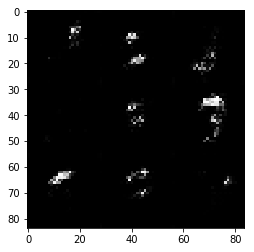

epoch: 1/2, discriminator loss: 4.084619045257568, generator loss: 0.026018166914582253
epoch: 1/2, discriminator loss: 3.7602083683013916, generator loss: 0.030118651688098907
epoch: 1/2, discriminator loss: 4.807957172393799, generator loss: 0.013867619447410107
epoch: 1/2, discriminator loss: 4.726922988891602, generator loss: 0.011093980632722378
epoch: 1/2, discriminator loss: 3.3389546871185303, generator loss: 0.07206037640571594
epoch: 1/2, discriminator loss: 3.1031203269958496, generator loss: 0.057545989751815796
epoch: 1/2, discriminator loss: 2.158644914627075, generator loss: 0.2395811825990677


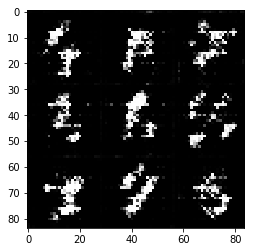

epoch: 1/2, discriminator loss: 2.831796169281006, generator loss: 0.1441657394170761
epoch: 1/2, discriminator loss: 2.882894277572632, generator loss: 0.09804756939411163
epoch: 1/2, discriminator loss: 4.283420562744141, generator loss: 0.022164490073919296
epoch: 1/2, discriminator loss: 2.752518892288208, generator loss: 0.09254739433526993
epoch: 1/2, discriminator loss: 2.9221444129943848, generator loss: 0.06357844918966293
epoch: 1/2, discriminator loss: 1.1521395444869995, generator loss: 0.6171982884407043
epoch: 1/2, discriminator loss: 2.4991273880004883, generator loss: 0.1283867359161377


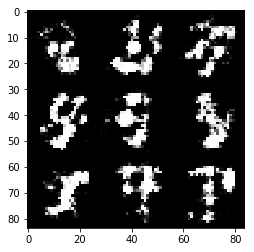

epoch: 1/2, discriminator loss: 1.4357695579528809, generator loss: 0.550654411315918
epoch: 1/2, discriminator loss: 2.21054744720459, generator loss: 0.18354877829551697
epoch: 1/2, discriminator loss: 3.3414268493652344, generator loss: 0.049240145832300186
epoch: 1/2, discriminator loss: 1.24032723903656, generator loss: 0.44012781977653503
epoch: 1/2, discriminator loss: 1.4964933395385742, generator loss: 0.3198484182357788
epoch: 1/2, discriminator loss: 1.5638407468795776, generator loss: 0.3362025320529938


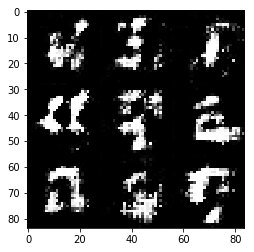

epoch: 1/2, discriminator loss: 2.002253770828247, generator loss: 0.1692190170288086
epoch: 1/2, discriminator loss: 1.7790007591247559, generator loss: 0.23419103026390076
epoch: 1/2, discriminator loss: 2.0737361907958984, generator loss: 0.16219660639762878
epoch: 1/2, discriminator loss: 1.8675116300582886, generator loss: 0.18730586767196655
epoch: 1/2, discriminator loss: 2.206913948059082, generator loss: 0.14308340847492218
epoch: 1/2, discriminator loss: 2.0015711784362793, generator loss: 0.16957269608974457
epoch: 1/2, discriminator loss: 1.4492387771606445, generator loss: 0.3673134446144104


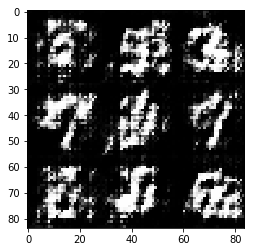

epoch: 1/2, discriminator loss: 2.0063908100128174, generator loss: 0.1566089540719986
epoch: 1/2, discriminator loss: 1.294684886932373, generator loss: 0.48776450753211975
epoch: 1/2, discriminator loss: 0.8738914728164673, generator loss: 0.5634969472885132
epoch: 1/2, discriminator loss: 1.3389613628387451, generator loss: 0.33167657256126404
epoch: 1/2, discriminator loss: 1.199418306350708, generator loss: 0.3826911747455597
epoch: 1/2, discriminator loss: 1.339647650718689, generator loss: 0.33848273754119873
epoch: 1/2, discriminator loss: 1.3240445852279663, generator loss: 0.3312968909740448


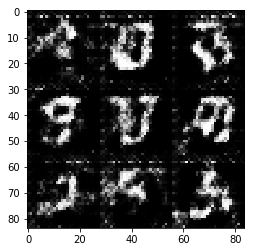

epoch: 1/2, discriminator loss: 1.37582528591156, generator loss: 0.3155401945114136
epoch: 1/2, discriminator loss: 0.9732800722122192, generator loss: 0.5275129079818726
epoch: 1/2, discriminator loss: 0.4165365695953369, generator loss: 1.2447398900985718
epoch: 1/2, discriminator loss: 0.45800697803497314, generator loss: 1.2463265657424927
epoch: 1/2, discriminator loss: 0.6697879433631897, generator loss: 0.8682618141174316
epoch: 1/2, discriminator loss: 1.307665467262268, generator loss: 0.3229478597640991


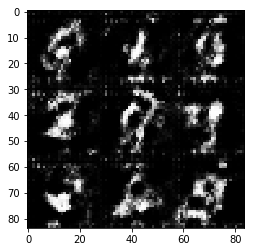

epoch: 1/2, discriminator loss: 0.4942404329776764, generator loss: 1.0394763946533203
epoch: 1/2, discriminator loss: 1.135558009147644, generator loss: 0.4046999514102936
epoch: 1/2, discriminator loss: 0.9837159514427185, generator loss: 0.4944821298122406
epoch: 1/2, discriminator loss: 1.0813673734664917, generator loss: 0.4540107548236847
epoch: 1/2, discriminator loss: 0.5691980123519897, generator loss: 0.9332371950149536
epoch: 1/2, discriminator loss: 0.9566430449485779, generator loss: 0.5078367590904236
epoch: 1/2, discriminator loss: 0.5984777808189392, generator loss: 0.8208109140396118


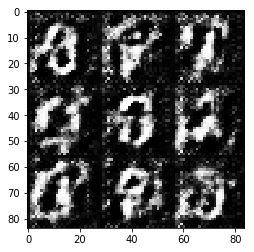

epoch: 1/2, discriminator loss: 0.35128575563430786, generator loss: 1.6410290002822876
epoch: 1/2, discriminator loss: 0.34102195501327515, generator loss: 1.3307313919067383
epoch: 1/2, discriminator loss: 2.6253628730773926, generator loss: 0.07688695937395096
epoch: 1/2, discriminator loss: 0.5758131146430969, generator loss: 0.8711973428726196
epoch: 1/2, discriminator loss: 1.3960416316986084, generator loss: 0.28865084052085876
epoch: 1/2, discriminator loss: 0.3351947069168091, generator loss: 1.425172209739685
epoch: 1/2, discriminator loss: 0.3874301314353943, generator loss: 1.2176861763000488


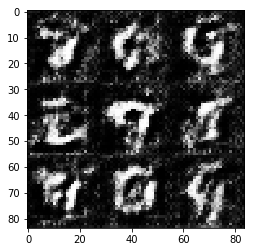

epoch: 1/2, discriminator loss: 0.23818457126617432, generator loss: 1.7214806079864502
epoch: 1/2, discriminator loss: 0.469488263130188, generator loss: 1.0569508075714111
epoch: 1/2, discriminator loss: 0.15476250648498535, generator loss: 2.022385358810425
epoch: 1/2, discriminator loss: 0.33002516627311707, generator loss: 1.4566748142242432
epoch: 1/2, discriminator loss: 0.3605938255786896, generator loss: 1.2466108798980713
epoch: 1/2, discriminator loss: 0.420973539352417, generator loss: 1.0911080837249756


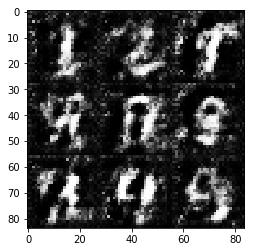

epoch: 1/2, discriminator loss: 0.17550013959407806, generator loss: 1.930611252784729
epoch: 1/2, discriminator loss: 0.26888060569763184, generator loss: 1.5014190673828125
epoch: 1/2, discriminator loss: 0.593755841255188, generator loss: 0.8101862668991089
epoch: 1/2, discriminator loss: 0.4442046880722046, generator loss: 1.072761058807373
epoch: 1/2, discriminator loss: 0.17978589236736298, generator loss: 1.9940612316131592
epoch: 1/2, discriminator loss: 0.8761415481567383, generator loss: 0.5484992861747742
epoch: 1/2, discriminator loss: 0.687407910823822, generator loss: 0.705720067024231


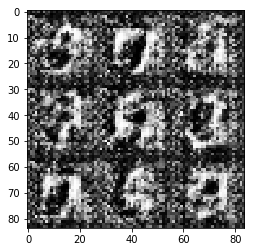

epoch: 1/2, discriminator loss: 0.2452782243490219, generator loss: 1.5537488460540771
epoch: 1/2, discriminator loss: 0.48346298933029175, generator loss: 0.9918522834777832
epoch: 1/2, discriminator loss: 0.16263744235038757, generator loss: 1.9680399894714355
epoch: 1/2, discriminator loss: 0.2508377730846405, generator loss: 1.5434250831604004
epoch: 1/2, discriminator loss: 0.17702357470989227, generator loss: 1.8882277011871338
epoch: 1/2, discriminator loss: 0.3039482831954956, generator loss: 1.3581606149673462
epoch: 1/2, discriminator loss: 0.22233946621418, generator loss: 1.6283620595932007


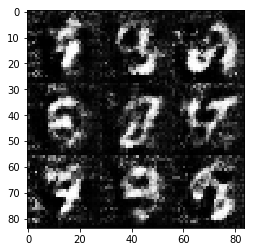

epoch: 1/2, discriminator loss: 0.805407702922821, generator loss: 0.5966593027114868
epoch: 1/2, discriminator loss: 0.09123270958662033, generator loss: 2.7676689624786377
epoch: 1/2, discriminator loss: 0.35453206300735474, generator loss: 1.2507014274597168
epoch: 1/2, discriminator loss: 0.623907208442688, generator loss: 0.7832509875297546
epoch: 1/2, discriminator loss: 0.3933371603488922, generator loss: 1.2130630016326904
epoch: 1/2, discriminator loss: 0.1595247983932495, generator loss: 2.0373950004577637


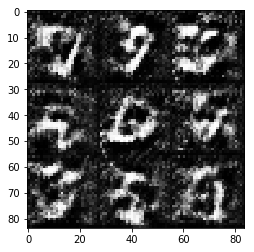

epoch: 1/2, discriminator loss: 0.2624099850654602, generator loss: 1.523356318473816
epoch: 1/2, discriminator loss: 0.1866871416568756, generator loss: 1.809281349182129
epoch: 1/2, discriminator loss: 0.6415551900863647, generator loss: 0.7603431940078735
epoch: 1/2, discriminator loss: 0.25113534927368164, generator loss: 1.5192530155181885
epoch: 1/2, discriminator loss: 0.7361324429512024, generator loss: 0.6618914008140564
epoch: 1/2, discriminator loss: 0.24627673625946045, generator loss: 1.5542093515396118
epoch: 1/2, discriminator loss: 0.1350651979446411, generator loss: 3.202202320098877


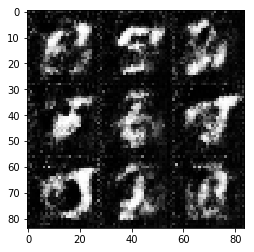

epoch: 1/2, discriminator loss: 0.05220211297273636, generator loss: 3.437957286834717
epoch: 1/2, discriminator loss: 0.038269564509391785, generator loss: 3.529747247695923
epoch: 1/2, discriminator loss: 0.16183213889598846, generator loss: 1.9216572046279907
epoch: 1/2, discriminator loss: 0.12492695450782776, generator loss: 2.1760005950927734
epoch: 1/2, discriminator loss: 0.2506616413593292, generator loss: 1.5184863805770874
epoch: 1/2, discriminator loss: 0.5369454622268677, generator loss: 0.8852525949478149
epoch: 1/2, discriminator loss: 0.07366763055324554, generator loss: 2.6758880615234375


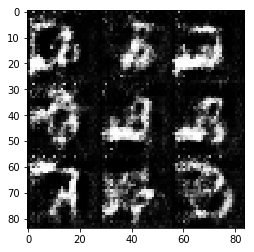

epoch: 1/2, discriminator loss: 0.1663520485162735, generator loss: 1.9387239217758179
epoch: 1/2, discriminator loss: 0.24121257662773132, generator loss: 1.5628430843353271
epoch: 1/2, discriminator loss: 0.05297938734292984, generator loss: 3.1240694522857666
epoch: 1/2, discriminator loss: 0.06236047297716141, generator loss: 3.0031325817108154
epoch: 1/2, discriminator loss: 0.10334502905607224, generator loss: 2.411365509033203
epoch: 1/2, discriminator loss: 0.11214154213666916, generator loss: 2.2670376300811768


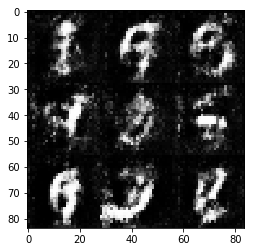

epoch: 1/2, discriminator loss: 0.06446294486522675, generator loss: 3.107114553451538
epoch: 1/2, discriminator loss: 0.0861256942152977, generator loss: 2.5152530670166016
epoch: 1/2, discriminator loss: 0.10703939199447632, generator loss: 2.311274766921997
epoch: 1/2, discriminator loss: 0.06146105006337166, generator loss: 2.958287239074707
epoch: 1/2, discriminator loss: 0.10906156897544861, generator loss: 2.3288238048553467
epoch: 1/2, discriminator loss: 0.07953570783138275, generator loss: 2.6085469722747803
epoch: 1/2, discriminator loss: 0.5309524536132812, generator loss: 0.889103889465332


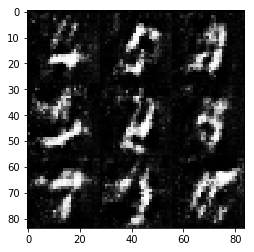

epoch: 1/2, discriminator loss: 0.12959690392017365, generator loss: 2.252584218978882
epoch: 1/2, discriminator loss: 0.11650975793600082, generator loss: 2.237710475921631
epoch: 1/2, discriminator loss: 0.10234636068344116, generator loss: 2.357028007507324
epoch: 1/2, discriminator loss: 0.04512564837932587, generator loss: 3.2195465564727783
epoch: 1/2, discriminator loss: 0.015525678172707558, generator loss: 4.520285129547119
epoch: 1/2, discriminator loss: 0.18798819184303284, generator loss: 1.8119440078735352
epoch: 1/2, discriminator loss: 0.05984712019562721, generator loss: 2.892935037612915


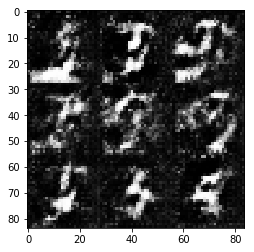

epoch: 1/2, discriminator loss: 0.07368858903646469, generator loss: 2.6815173625946045
epoch: 1/2, discriminator loss: 0.21831747889518738, generator loss: 1.6540279388427734
epoch: 1/2, discriminator loss: 0.08232958614826202, generator loss: 2.5838499069213867
epoch: 1/2, discriminator loss: 0.06949401646852493, generator loss: 2.770235300064087
epoch: 1/2, discriminator loss: 0.16258269548416138, generator loss: 1.953151822090149
epoch: 2/2, discriminator loss: 0.03256002813577652, generator loss: 3.5057289600372314
epoch: 2/2, discriminator loss: 0.043217677623033524, generator loss: 3.2211947441101074
epoch: 2/2, discriminator loss: 0.04851687327027321, generator loss: 3.115570545196533
epoch: 2/2, discriminator loss: 0.05706144496798515, generator loss: 2.961012125015259
epoch: 2/2, discriminator loss: 0.03380239009857178, generator loss: 3.536541700363159
epoch: 2/2, discriminator loss: 0.027787765488028526, generator loss: 3.768181562423706


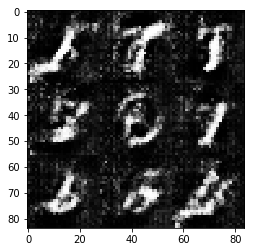

epoch: 2/2, discriminator loss: 0.027655597776174545, generator loss: 3.69693660736084
epoch: 2/2, discriminator loss: 0.05527656897902489, generator loss: 3.0075910091400146
epoch: 2/2, discriminator loss: 0.05607396736741066, generator loss: 3.0377426147460938
epoch: 2/2, discriminator loss: 0.06702260673046112, generator loss: 2.8211188316345215
epoch: 2/2, discriminator loss: 0.037297509610652924, generator loss: 3.425187587738037
epoch: 2/2, discriminator loss: 0.02762795425951481, generator loss: 3.66650390625
epoch: 2/2, discriminator loss: 0.0377684161067009, generator loss: 3.4183568954467773


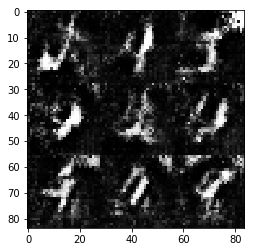

epoch: 2/2, discriminator loss: 0.050810929387807846, generator loss: 3.1648387908935547
epoch: 2/2, discriminator loss: 0.050939492881298065, generator loss: 3.0534393787384033
epoch: 2/2, discriminator loss: 0.10996454954147339, generator loss: 2.3475005626678467
epoch: 2/2, discriminator loss: 0.031891830265522, generator loss: 3.6666505336761475
epoch: 2/2, discriminator loss: 0.03260401636362076, generator loss: 3.513395071029663
epoch: 2/2, discriminator loss: 0.05622909590601921, generator loss: 3.1664206981658936
epoch: 2/2, discriminator loss: 0.04831692576408386, generator loss: 3.1011321544647217


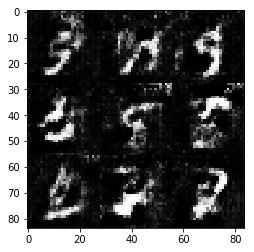

epoch: 2/2, discriminator loss: 0.20709280669689178, generator loss: 1.7087867259979248
epoch: 2/2, discriminator loss: 0.016317173838615417, generator loss: 4.214170455932617
epoch: 2/2, discriminator loss: 0.0754593163728714, generator loss: 2.7222602367401123
epoch: 2/2, discriminator loss: 0.03459811210632324, generator loss: 3.4480106830596924
epoch: 2/2, discriminator loss: 0.18101857602596283, generator loss: 1.8044124841690063
epoch: 2/2, discriminator loss: 0.10237658768892288, generator loss: 2.3472847938537598


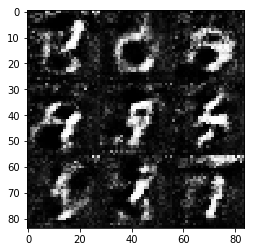

epoch: 2/2, discriminator loss: 0.05578068271279335, generator loss: 2.9602437019348145
epoch: 2/2, discriminator loss: 0.022044409066438675, generator loss: 4.093830585479736
epoch: 2/2, discriminator loss: 0.12705360352993011, generator loss: 2.165468454360962
epoch: 2/2, discriminator loss: 0.04242914170026779, generator loss: 3.2171876430511475
epoch: 2/2, discriminator loss: 0.04100839048624039, generator loss: 3.3020272254943848
epoch: 2/2, discriminator loss: 0.05491548404097557, generator loss: 3.0999319553375244
epoch: 2/2, discriminator loss: 0.07863646745681763, generator loss: 2.625286817550659


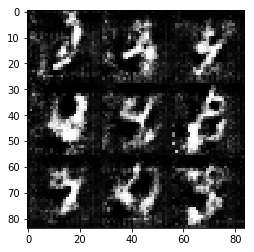

epoch: 2/2, discriminator loss: 0.04187088832259178, generator loss: 3.238226890563965
epoch: 2/2, discriminator loss: 0.02927536703646183, generator loss: 3.627750873565674
epoch: 2/2, discriminator loss: 0.10070577263832092, generator loss: 2.3562562465667725
epoch: 2/2, discriminator loss: 0.033851128071546555, generator loss: 3.4658496379852295
epoch: 2/2, discriminator loss: 0.04806141182780266, generator loss: 3.0754640102386475
epoch: 2/2, discriminator loss: 0.014872889965772629, generator loss: 4.996276378631592
epoch: 2/2, discriminator loss: 0.01040655467659235, generator loss: 4.774072170257568


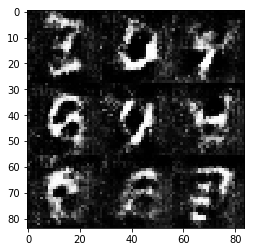

epoch: 2/2, discriminator loss: 0.10999947041273117, generator loss: 2.3160853385925293
epoch: 2/2, discriminator loss: 0.007281025405973196, generator loss: 5.120278835296631
epoch: 2/2, discriminator loss: 0.02369999885559082, generator loss: 3.869474172592163
epoch: 2/2, discriminator loss: 0.029984306544065475, generator loss: 3.5613911151885986
epoch: 2/2, discriminator loss: 0.08020681142807007, generator loss: 2.5876588821411133
epoch: 2/2, discriminator loss: 0.06882684677839279, generator loss: 2.7173221111297607


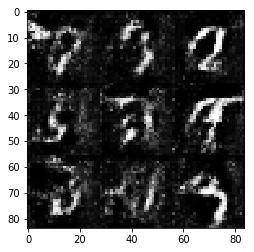

epoch: 2/2, discriminator loss: 0.016193373128771782, generator loss: 4.203319072723389
epoch: 2/2, discriminator loss: 0.042862437665462494, generator loss: 3.2232632637023926
epoch: 2/2, discriminator loss: 0.03686508536338806, generator loss: 3.3660900592803955
epoch: 2/2, discriminator loss: 0.09049006551504135, generator loss: 2.46591854095459
epoch: 2/2, discriminator loss: 0.021501827985048294, generator loss: 3.9766883850097656
epoch: 2/2, discriminator loss: 0.019101589918136597, generator loss: 4.076296806335449
epoch: 2/2, discriminator loss: 0.030291615054011345, generator loss: 3.565796375274658


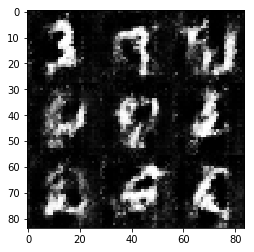

epoch: 2/2, discriminator loss: 0.026747670024633408, generator loss: 3.7081210613250732
epoch: 2/2, discriminator loss: 0.026389632374048233, generator loss: 3.699885845184326
epoch: 2/2, discriminator loss: 0.026777463033795357, generator loss: 3.6685991287231445
epoch: 2/2, discriminator loss: 0.03742072731256485, generator loss: 3.3402316570281982
epoch: 2/2, discriminator loss: 0.010969731956720352, generator loss: 4.608798503875732
epoch: 2/2, discriminator loss: 0.017591988667845726, generator loss: 4.353765487670898
epoch: 2/2, discriminator loss: 0.012998171150684357, generator loss: 4.518524169921875


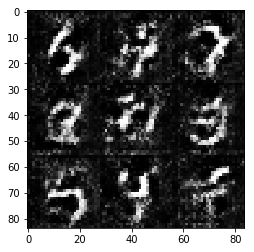

epoch: 2/2, discriminator loss: 0.02456727623939514, generator loss: 3.8002450466156006
epoch: 2/2, discriminator loss: 0.041402868926525116, generator loss: 3.354504108428955
epoch: 2/2, discriminator loss: 0.032880935817956924, generator loss: 3.460465669631958
epoch: 2/2, discriminator loss: 0.04016171023249626, generator loss: 3.4276440143585205
epoch: 2/2, discriminator loss: 0.019470224156975746, generator loss: 4.069118976593018
epoch: 2/2, discriminator loss: 0.03116459585726261, generator loss: 3.5027987957000732


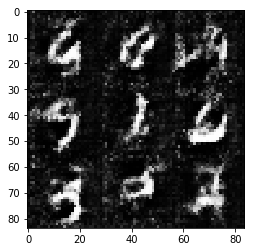

epoch: 2/2, discriminator loss: 0.03612632676959038, generator loss: 3.392803907394409
epoch: 2/2, discriminator loss: 0.005125341936945915, generator loss: 5.481483459472656
epoch: 2/2, discriminator loss: 0.06266064196825027, generator loss: 2.8122968673706055
epoch: 2/2, discriminator loss: 0.022919727489352226, generator loss: 3.850480318069458
epoch: 2/2, discriminator loss: 0.019521547481417656, generator loss: 4.14560604095459
epoch: 2/2, discriminator loss: 0.01642039604485035, generator loss: 4.179704189300537
epoch: 2/2, discriminator loss: 0.021717984229326248, generator loss: 3.8593649864196777


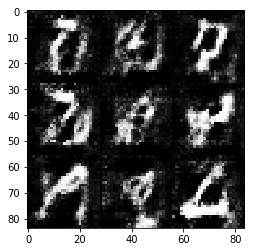

epoch: 2/2, discriminator loss: 0.012520051561295986, generator loss: 4.447377681732178
epoch: 2/2, discriminator loss: 0.04593459144234657, generator loss: 3.191221237182617
epoch: 2/2, discriminator loss: 0.02147306688129902, generator loss: 3.88257098197937
epoch: 2/2, discriminator loss: 0.011005326174199581, generator loss: 4.63267183303833
epoch: 2/2, discriminator loss: 0.007715187966823578, generator loss: 5.121590614318848
epoch: 2/2, discriminator loss: 0.02352207526564598, generator loss: 3.788759231567383
epoch: 2/2, discriminator loss: 0.010533370077610016, generator loss: 4.591154098510742


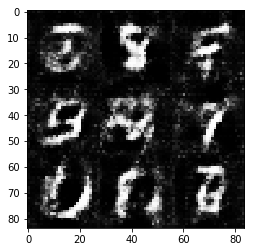

epoch: 2/2, discriminator loss: 0.022159574553370476, generator loss: 3.8400330543518066
epoch: 2/2, discriminator loss: 0.01601879671216011, generator loss: 4.277672290802002
epoch: 2/2, discriminator loss: 0.006946146488189697, generator loss: 5.196190357208252
epoch: 2/2, discriminator loss: 0.016491075977683067, generator loss: 4.251126289367676
epoch: 2/2, discriminator loss: 0.06077607348561287, generator loss: 2.920074224472046
epoch: 2/2, discriminator loss: 0.010361172258853912, generator loss: 4.781126022338867


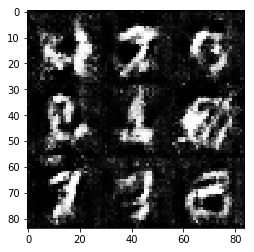

epoch: 2/2, discriminator loss: 0.013906321488320827, generator loss: 4.47551155090332
epoch: 2/2, discriminator loss: 0.0047471350990235806, generator loss: 5.511924743652344
epoch: 2/2, discriminator loss: 0.013155186548829079, generator loss: 4.494104385375977
epoch: 2/2, discriminator loss: 0.028154797852039337, generator loss: 3.6081700325012207
epoch: 2/2, discriminator loss: 0.019082868471741676, generator loss: 4.0263495445251465
epoch: 2/2, discriminator loss: 0.008400545455515385, generator loss: 5.031311511993408
epoch: 2/2, discriminator loss: 0.014195444993674755, generator loss: 4.3063178062438965


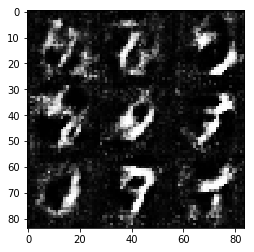

epoch: 2/2, discriminator loss: 0.010360765270888805, generator loss: 4.727746486663818
epoch: 2/2, discriminator loss: 0.010417182929813862, generator loss: 4.635601997375488
epoch: 2/2, discriminator loss: 0.006623431108891964, generator loss: 5.080177307128906
epoch: 2/2, discriminator loss: 0.004129253327846527, generator loss: 5.554915428161621
epoch: 2/2, discriminator loss: 0.012784186750650406, generator loss: 4.402211666107178
epoch: 2/2, discriminator loss: 0.009798341430723667, generator loss: 4.725432872772217
epoch: 2/2, discriminator loss: 0.0966261476278305, generator loss: 2.3867404460906982


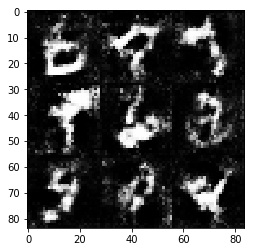

epoch: 2/2, discriminator loss: 0.009943332523107529, generator loss: 4.713670253753662
epoch: 2/2, discriminator loss: 0.00531677296385169, generator loss: 5.4088568687438965
epoch: 2/2, discriminator loss: 0.012438605539500713, generator loss: 4.471218109130859
epoch: 2/2, discriminator loss: 0.003986387979239225, generator loss: 5.968138217926025
epoch: 2/2, discriminator loss: 0.01516749057918787, generator loss: 4.299966812133789
epoch: 2/2, discriminator loss: 0.004055121913552284, generator loss: 5.599388599395752


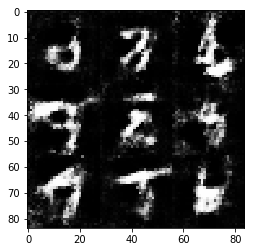

epoch: 2/2, discriminator loss: 0.005504711531102657, generator loss: 6.239095687866211
epoch: 2/2, discriminator loss: 0.029058000072836876, generator loss: 3.564150094985962
epoch: 2/2, discriminator loss: 0.003817173885181546, generator loss: 5.646999359130859
epoch: 2/2, discriminator loss: 0.013428684324026108, generator loss: 4.380768775939941
epoch: 2/2, discriminator loss: 0.008684687316417694, generator loss: 4.834832668304443
epoch: 2/2, discriminator loss: 0.010214335285127163, generator loss: 4.620234489440918
epoch: 2/2, discriminator loss: 0.07142332196235657, generator loss: 2.6775128841400146


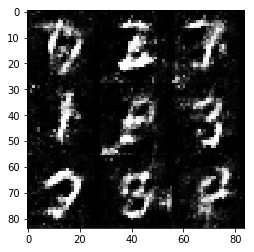

epoch: 2/2, discriminator loss: 0.036744434386491776, generator loss: 3.4143669605255127
epoch: 2/2, discriminator loss: 0.02938566356897354, generator loss: 3.5490036010742188
epoch: 2/2, discriminator loss: 0.008767543360590935, generator loss: 4.786806106567383
epoch: 2/2, discriminator loss: 0.02785986289381981, generator loss: 3.6090312004089355
epoch: 2/2, discriminator loss: 0.007408324629068375, generator loss: 4.961790084838867
epoch: 2/2, discriminator loss: 0.007812178693711758, generator loss: 5.162130355834961
epoch: 2/2, discriminator loss: 0.008730816654860973, generator loss: 4.777533054351807


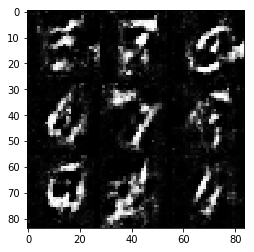

epoch: 2/2, discriminator loss: 0.009158266708254814, generator loss: 4.747076988220215
epoch: 2/2, discriminator loss: 0.006928157061338425, generator loss: 5.088354587554932
epoch: 2/2, discriminator loss: 0.00468393275514245, generator loss: 5.4920196533203125
epoch: 2/2, discriminator loss: 0.004924255423247814, generator loss: 5.585453510284424
epoch: 2/2, discriminator loss: 0.012052240781486034, generator loss: 4.582295894622803


In [27]:
batch_size = 32
z_dim = 140
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

epoch: 1/1, discriminator loss: 5.746199607849121, generator loss: 0.005260974168777466
epoch: 1/1, discriminator loss: 4.731492042541504, generator loss: 0.021181680262088776
epoch: 1/1, discriminator loss: 3.4334070682525635, generator loss: 0.04578734561800957
epoch: 1/1, discriminator loss: 4.0210676193237305, generator loss: 0.028948521241545677
epoch: 1/1, discriminator loss: 3.9593589305877686, generator loss: 0.03361474350094795
epoch: 1/1, discriminator loss: 4.050938129425049, generator loss: 0.032880749553442


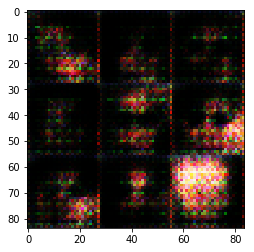

epoch: 1/1, discriminator loss: 3.4084012508392334, generator loss: 0.08900813013315201
epoch: 1/1, discriminator loss: 4.009872913360596, generator loss: 0.025923527777194977
epoch: 1/1, discriminator loss: 5.033936023712158, generator loss: 0.007986336015164852
epoch: 1/1, discriminator loss: 5.848903656005859, generator loss: 0.004335607867687941
epoch: 1/1, discriminator loss: 5.412912368774414, generator loss: 0.006633162498474121
epoch: 1/1, discriminator loss: 1.8949635028839111, generator loss: 0.2810746133327484
epoch: 1/1, discriminator loss: 3.7872350215911865, generator loss: 0.026564890518784523


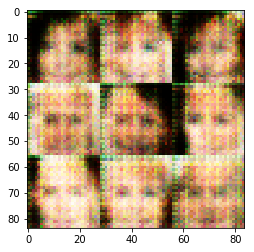

epoch: 1/1, discriminator loss: 4.198980331420898, generator loss: 0.07113834470510483
epoch: 1/1, discriminator loss: 3.27009916305542, generator loss: 0.043562471866607666
epoch: 1/1, discriminator loss: 4.196073055267334, generator loss: 0.018261944875121117
epoch: 1/1, discriminator loss: 3.239528179168701, generator loss: 0.058818649500608444
epoch: 1/1, discriminator loss: 3.2293968200683594, generator loss: 0.06548335403203964
epoch: 1/1, discriminator loss: 4.507774353027344, generator loss: 0.015947803854942322
epoch: 1/1, discriminator loss: 2.9824094772338867, generator loss: 0.07086695730686188


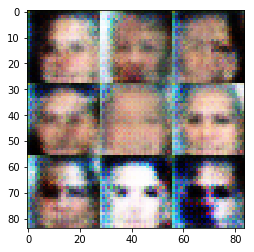

epoch: 1/1, discriminator loss: 3.211062431335449, generator loss: 0.08509133011102676
epoch: 1/1, discriminator loss: 3.450253963470459, generator loss: 0.03653814271092415
epoch: 1/1, discriminator loss: 3.7439212799072266, generator loss: 0.03400442376732826
epoch: 1/1, discriminator loss: 3.788055658340454, generator loss: 0.041175391525030136
epoch: 1/1, discriminator loss: 3.444824457168579, generator loss: 0.055528730154037476
epoch: 1/1, discriminator loss: 3.2058606147766113, generator loss: 0.059312086552381516


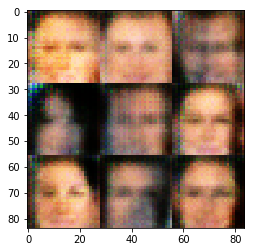

epoch: 1/1, discriminator loss: 2.3412184715270996, generator loss: 0.21821396052837372
epoch: 1/1, discriminator loss: 2.8885295391082764, generator loss: 0.0924069881439209
epoch: 1/1, discriminator loss: 3.06054949760437, generator loss: 0.059640586376190186
epoch: 1/1, discriminator loss: 2.569706678390503, generator loss: 0.09874489903450012
epoch: 1/1, discriminator loss: 2.2776052951812744, generator loss: 0.1938977986574173
epoch: 1/1, discriminator loss: 2.675999641418457, generator loss: 0.09856321662664413
epoch: 1/1, discriminator loss: 3.087380886077881, generator loss: 0.0673922523856163


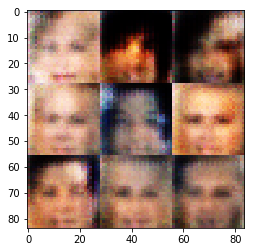

epoch: 1/1, discriminator loss: 2.1370694637298584, generator loss: 0.3183608651161194
epoch: 1/1, discriminator loss: 2.681627035140991, generator loss: 0.28438451886177063
epoch: 1/1, discriminator loss: 2.721468210220337, generator loss: 0.12359257787466049
epoch: 1/1, discriminator loss: 2.098395347595215, generator loss: 0.21485690772533417
epoch: 1/1, discriminator loss: 3.0595552921295166, generator loss: 0.07257726788520813
epoch: 1/1, discriminator loss: 1.2331806421279907, generator loss: 0.5426831841468811
epoch: 1/1, discriminator loss: 1.7566111087799072, generator loss: 0.3158635199069977


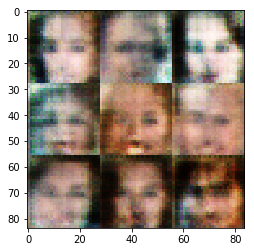

epoch: 1/1, discriminator loss: 2.3815805912017822, generator loss: 0.22919662296772003
epoch: 1/1, discriminator loss: 1.3050109148025513, generator loss: 0.4991873800754547
epoch: 1/1, discriminator loss: 2.4742379188537598, generator loss: 0.11712298542261124
epoch: 1/1, discriminator loss: 1.8867309093475342, generator loss: 0.2212139219045639
epoch: 1/1, discriminator loss: 2.153543472290039, generator loss: 0.15473900735378265
epoch: 1/1, discriminator loss: 0.8411122560501099, generator loss: 0.926058828830719


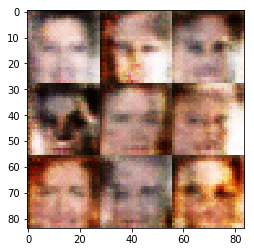

epoch: 1/1, discriminator loss: 1.4621042013168335, generator loss: 0.41455164551734924
epoch: 1/1, discriminator loss: 1.5837457180023193, generator loss: 0.32568180561065674
epoch: 1/1, discriminator loss: 1.8478610515594482, generator loss: 0.24216270446777344
epoch: 1/1, discriminator loss: 0.8858433961868286, generator loss: 0.6933832168579102
epoch: 1/1, discriminator loss: 0.7703876495361328, generator loss: 1.0142046213150024
epoch: 1/1, discriminator loss: 2.3708248138427734, generator loss: 0.11380752176046371
epoch: 1/1, discriminator loss: 1.3564300537109375, generator loss: 0.41193386912345886


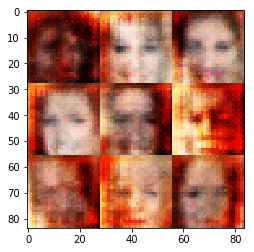

epoch: 1/1, discriminator loss: 1.026208519935608, generator loss: 0.48549285531044006
epoch: 1/1, discriminator loss: 1.2702895402908325, generator loss: 0.41854801774024963
epoch: 1/1, discriminator loss: 1.5375385284423828, generator loss: 0.2680695354938507
epoch: 1/1, discriminator loss: 2.1013193130493164, generator loss: 0.15021736919879913
epoch: 1/1, discriminator loss: 1.3102830648422241, generator loss: 0.41830530762672424
epoch: 1/1, discriminator loss: 1.4345146417617798, generator loss: 0.29543015360832214
epoch: 1/1, discriminator loss: 1.3919352293014526, generator loss: 0.3230721652507782


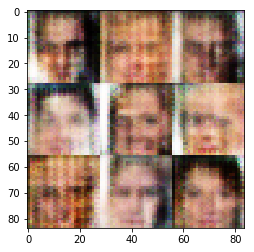

epoch: 1/1, discriminator loss: 1.6622257232666016, generator loss: 0.2822222411632538
epoch: 1/1, discriminator loss: 1.4552719593048096, generator loss: 0.3767869174480438
epoch: 1/1, discriminator loss: 0.46278616786003113, generator loss: 1.6815696954727173
epoch: 1/1, discriminator loss: 1.085628867149353, generator loss: 0.5741927027702332
epoch: 1/1, discriminator loss: 2.3118982315063477, generator loss: 0.11426007747650146
epoch: 1/1, discriminator loss: 1.6882861852645874, generator loss: 0.23204658925533295


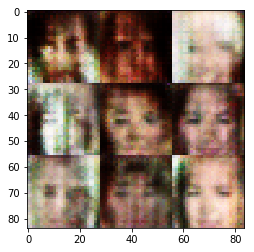

epoch: 1/1, discriminator loss: 0.9606691598892212, generator loss: 0.6156604290008545
epoch: 1/1, discriminator loss: 1.4473223686218262, generator loss: 0.3429037034511566
epoch: 1/1, discriminator loss: 1.634399652481079, generator loss: 0.25411257147789
epoch: 1/1, discriminator loss: 0.6262643337249756, generator loss: 0.9766157269477844
epoch: 1/1, discriminator loss: 1.4008688926696777, generator loss: 0.41049596667289734
epoch: 1/1, discriminator loss: 0.837730348110199, generator loss: 0.6800162196159363
epoch: 1/1, discriminator loss: 1.1899149417877197, generator loss: 0.40599584579467773


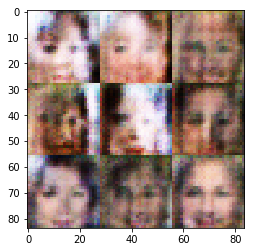

epoch: 1/1, discriminator loss: 1.6630266904830933, generator loss: 0.28294721245765686
epoch: 1/1, discriminator loss: 0.8171125650405884, generator loss: 0.7103171348571777
epoch: 1/1, discriminator loss: 0.9788154363632202, generator loss: 0.5571275353431702
epoch: 1/1, discriminator loss: 1.180738091468811, generator loss: 0.5204524993896484
epoch: 1/1, discriminator loss: 0.6887530088424683, generator loss: 0.9783024787902832
epoch: 1/1, discriminator loss: 0.906573474407196, generator loss: 0.6580402255058289
epoch: 1/1, discriminator loss: 1.5105853080749512, generator loss: 0.29872798919677734


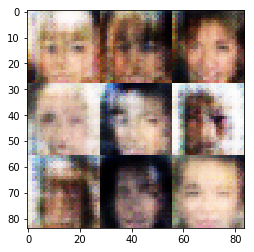

epoch: 1/1, discriminator loss: 0.7867873907089233, generator loss: 0.7667078971862793
epoch: 1/1, discriminator loss: 1.0683273077011108, generator loss: 0.5307788252830505
epoch: 1/1, discriminator loss: 1.242201328277588, generator loss: 0.42028501629829407
epoch: 1/1, discriminator loss: 0.7290618419647217, generator loss: 0.6910989284515381
epoch: 1/1, discriminator loss: 0.6649413704872131, generator loss: 0.8722143173217773
epoch: 1/1, discriminator loss: 0.5675750970840454, generator loss: 1.1114776134490967


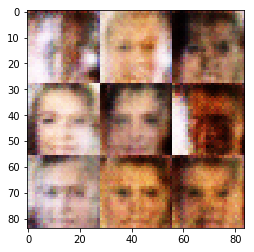

epoch: 1/1, discriminator loss: 0.5974902510643005, generator loss: 1.128373622894287
epoch: 1/1, discriminator loss: 0.9941670298576355, generator loss: 0.5983426570892334
epoch: 1/1, discriminator loss: 0.8374426364898682, generator loss: 0.7288396954536438
epoch: 1/1, discriminator loss: 0.9996508359909058, generator loss: 0.5423972010612488
epoch: 1/1, discriminator loss: 0.7878555059432983, generator loss: 0.6659970879554749
epoch: 1/1, discriminator loss: 1.3183904886245728, generator loss: 0.3750239312648773
epoch: 1/1, discriminator loss: 0.6061217784881592, generator loss: 0.825808048248291


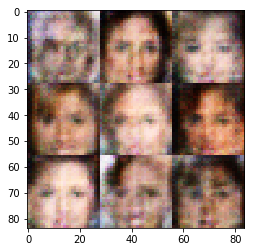

epoch: 1/1, discriminator loss: 1.8814020156860352, generator loss: 0.18082523345947266
epoch: 1/1, discriminator loss: 0.6157152652740479, generator loss: 0.867186963558197
epoch: 1/1, discriminator loss: 1.0189868211746216, generator loss: 0.483262300491333
epoch: 1/1, discriminator loss: 0.48547032475471497, generator loss: 0.9791452288627625
epoch: 1/1, discriminator loss: 1.2424005270004272, generator loss: 0.3822217881679535
epoch: 1/1, discriminator loss: 0.646172046661377, generator loss: 0.8220295906066895
epoch: 1/1, discriminator loss: 0.815239667892456, generator loss: 0.6676342487335205


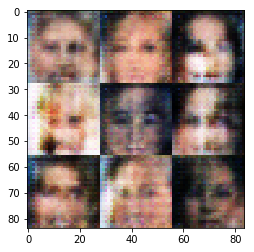

epoch: 1/1, discriminator loss: 2.0974931716918945, generator loss: 0.20245254039764404
epoch: 1/1, discriminator loss: 0.34317946434020996, generator loss: 1.3964614868164062
epoch: 1/1, discriminator loss: 0.6135714054107666, generator loss: 0.8901419639587402
epoch: 1/1, discriminator loss: 0.6282404661178589, generator loss: 0.9563713669776917
epoch: 1/1, discriminator loss: 0.5230933427810669, generator loss: 0.946627140045166
epoch: 1/1, discriminator loss: 0.7085601091384888, generator loss: 0.7421254515647888


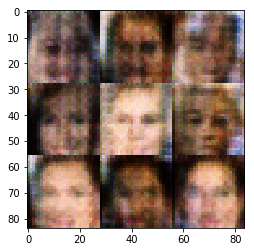

epoch: 1/1, discriminator loss: 0.36192500591278076, generator loss: 1.2348097562789917
epoch: 1/1, discriminator loss: 0.6064701080322266, generator loss: 0.8670191168785095
epoch: 1/1, discriminator loss: 2.0201754570007324, generator loss: 0.17807774245738983
epoch: 1/1, discriminator loss: 0.4880881905555725, generator loss: 1.1206941604614258
epoch: 1/1, discriminator loss: 0.4295226037502289, generator loss: 1.2732247114181519
epoch: 1/1, discriminator loss: 0.48938411474227905, generator loss: 1.5436829328536987
epoch: 1/1, discriminator loss: 0.5630136728286743, generator loss: 1.0280243158340454


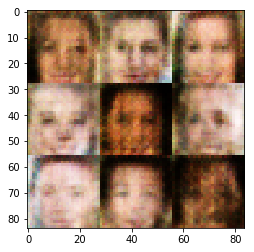

epoch: 1/1, discriminator loss: 0.14789119362831116, generator loss: 2.991295576095581
epoch: 1/1, discriminator loss: 0.5211519002914429, generator loss: 1.5641709566116333
epoch: 1/1, discriminator loss: 0.6744873523712158, generator loss: 0.8185016512870789
epoch: 1/1, discriminator loss: 0.7416117191314697, generator loss: 0.7051445841789246
epoch: 1/1, discriminator loss: 0.5289704203605652, generator loss: 0.9553335309028625
epoch: 1/1, discriminator loss: 0.2629745304584503, generator loss: 1.5877898931503296
epoch: 1/1, discriminator loss: 0.8038679361343384, generator loss: 0.7390413880348206


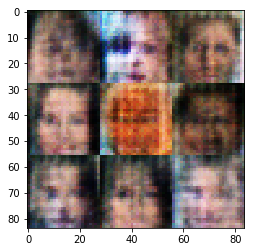

epoch: 1/1, discriminator loss: 1.7080881595611572, generator loss: 0.3280121684074402
epoch: 1/1, discriminator loss: 0.4386560022830963, generator loss: 1.0692267417907715
epoch: 1/1, discriminator loss: 0.18532896041870117, generator loss: 2.181035041809082
epoch: 1/1, discriminator loss: 0.7638177871704102, generator loss: 0.6954734921455383
epoch: 1/1, discriminator loss: 0.21553155779838562, generator loss: 1.6817121505737305
epoch: 1/1, discriminator loss: 0.5507791638374329, generator loss: 0.8755207657814026


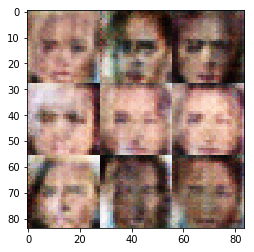

epoch: 1/1, discriminator loss: 0.2850247919559479, generator loss: 1.530471920967102
epoch: 1/1, discriminator loss: 0.12167932838201523, generator loss: 2.3412516117095947
epoch: 1/1, discriminator loss: 0.5247030258178711, generator loss: 0.9554736614227295
epoch: 1/1, discriminator loss: 0.2334217131137848, generator loss: 1.8280253410339355
epoch: 1/1, discriminator loss: 0.3877076208591461, generator loss: 1.4450570344924927
epoch: 1/1, discriminator loss: 0.2639825940132141, generator loss: 1.9641703367233276
epoch: 1/1, discriminator loss: 0.57002192735672, generator loss: 0.8853025436401367


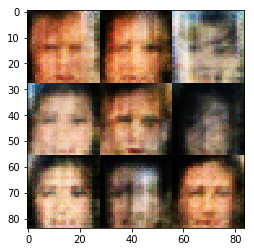

epoch: 1/1, discriminator loss: 0.2125777304172516, generator loss: 1.8359755277633667
epoch: 1/1, discriminator loss: 0.3487057685852051, generator loss: 1.360852837562561
epoch: 1/1, discriminator loss: 0.6631746292114258, generator loss: 1.1037346124649048
epoch: 1/1, discriminator loss: 0.6706133484840393, generator loss: 0.7726612091064453
epoch: 1/1, discriminator loss: 0.864570677280426, generator loss: 0.6072768568992615
epoch: 1/1, discriminator loss: 0.6250896453857422, generator loss: 1.0770862102508545
epoch: 1/1, discriminator loss: 0.2679328918457031, generator loss: 2.9788825511932373


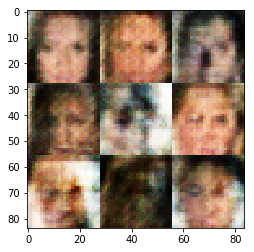

epoch: 1/1, discriminator loss: 0.36268648505210876, generator loss: 1.7662277221679688
epoch: 1/1, discriminator loss: 0.7134290933609009, generator loss: 0.8027461171150208
epoch: 1/1, discriminator loss: 0.7987850308418274, generator loss: 0.6142113208770752
epoch: 1/1, discriminator loss: 0.6419978141784668, generator loss: 0.8693084120750427
epoch: 1/1, discriminator loss: 0.3297302722930908, generator loss: 1.339395523071289
epoch: 1/1, discriminator loss: 0.22940915822982788, generator loss: 1.7869586944580078


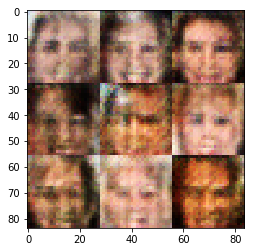

epoch: 1/1, discriminator loss: 0.32817327976226807, generator loss: 1.538624882698059
epoch: 1/1, discriminator loss: 0.21510088443756104, generator loss: 1.9567283391952515
epoch: 1/1, discriminator loss: 0.5890471339225769, generator loss: 0.8856903910636902
epoch: 1/1, discriminator loss: 0.06446011364459991, generator loss: 3.3013553619384766
epoch: 1/1, discriminator loss: 0.16130772233009338, generator loss: 2.0797526836395264
epoch: 1/1, discriminator loss: 0.08578179776668549, generator loss: 2.74448299407959
epoch: 1/1, discriminator loss: 0.3105330467224121, generator loss: 1.4538450241088867


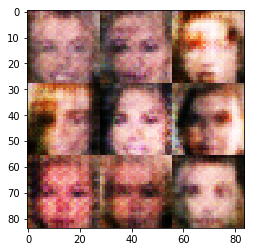

epoch: 1/1, discriminator loss: 0.5104987621307373, generator loss: 1.0012284517288208
epoch: 1/1, discriminator loss: 0.1886124312877655, generator loss: 1.9963337182998657
epoch: 1/1, discriminator loss: 0.1763337105512619, generator loss: 2.0274689197540283
epoch: 1/1, discriminator loss: 0.16263547539710999, generator loss: 2.0573623180389404
epoch: 1/1, discriminator loss: 0.1963830590248108, generator loss: 1.8544530868530273
epoch: 1/1, discriminator loss: 0.12630580365657806, generator loss: 2.142786979675293
epoch: 1/1, discriminator loss: 0.11500230431556702, generator loss: 2.26920485496521


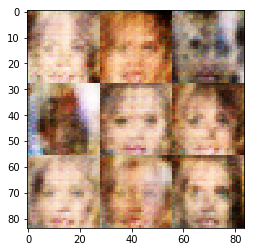

epoch: 1/1, discriminator loss: 0.3160240948200226, generator loss: 1.539154052734375
epoch: 1/1, discriminator loss: 0.2916407883167267, generator loss: 1.4251834154129028
epoch: 1/1, discriminator loss: 0.12107251584529877, generator loss: 2.4176762104034424
epoch: 1/1, discriminator loss: 0.3729882538318634, generator loss: 1.2560871839523315
epoch: 1/1, discriminator loss: 0.09943192452192307, generator loss: 2.4016854763031006
epoch: 1/1, discriminator loss: 0.35225510597229004, generator loss: 1.4336576461791992


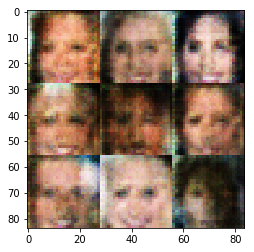

epoch: 1/1, discriminator loss: 0.3323103189468384, generator loss: 1.2745716571807861
epoch: 1/1, discriminator loss: 0.1897737681865692, generator loss: 1.921404480934143
epoch: 1/1, discriminator loss: 0.9239867925643921, generator loss: 1.8502264022827148
epoch: 1/1, discriminator loss: 0.2513067424297333, generator loss: 1.8666001558303833
epoch: 1/1, discriminator loss: 0.32137197256088257, generator loss: 1.863038182258606
epoch: 1/1, discriminator loss: 0.1485431045293808, generator loss: 2.7517690658569336
epoch: 1/1, discriminator loss: 0.3170565366744995, generator loss: 1.3997505903244019


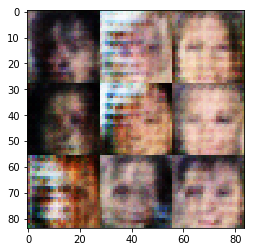

epoch: 1/1, discriminator loss: 0.10676456242799759, generator loss: 2.500990629196167
epoch: 1/1, discriminator loss: 0.28521525859832764, generator loss: 1.4284858703613281
epoch: 1/1, discriminator loss: 0.3430327773094177, generator loss: 1.3823355436325073
epoch: 1/1, discriminator loss: 1.0575752258300781, generator loss: 0.46946191787719727
epoch: 1/1, discriminator loss: 0.15399771928787231, generator loss: 2.052464246749878
epoch: 1/1, discriminator loss: 0.11987944692373276, generator loss: 2.7571163177490234
epoch: 1/1, discriminator loss: 0.4471387565135956, generator loss: 1.1912018060684204


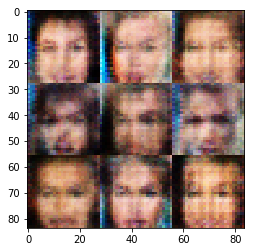

epoch: 1/1, discriminator loss: 0.2567879557609558, generator loss: 1.6860109567642212
epoch: 1/1, discriminator loss: 0.06577467173337936, generator loss: 3.3221466541290283
epoch: 1/1, discriminator loss: 0.890981912612915, generator loss: 1.429233193397522
epoch: 1/1, discriminator loss: 0.43155696988105774, generator loss: 1.2048097848892212
epoch: 1/1, discriminator loss: 0.34265267848968506, generator loss: 1.8288989067077637
epoch: 1/1, discriminator loss: 0.3260851800441742, generator loss: 1.4259008169174194


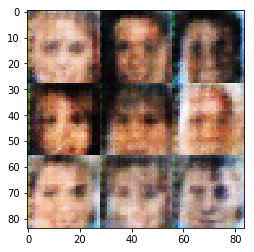

epoch: 1/1, discriminator loss: 0.28993096947669983, generator loss: 2.198582887649536
epoch: 1/1, discriminator loss: 0.4385340213775635, generator loss: 1.2138351202011108
epoch: 1/1, discriminator loss: 0.4511520564556122, generator loss: 2.930757761001587
epoch: 1/1, discriminator loss: 0.19391781091690063, generator loss: 2.2024004459381104
epoch: 1/1, discriminator loss: 0.1755290925502777, generator loss: 2.0949628353118896
epoch: 1/1, discriminator loss: 0.598491907119751, generator loss: 1.045032024383545
epoch: 1/1, discriminator loss: 0.25847119092941284, generator loss: 1.733364462852478


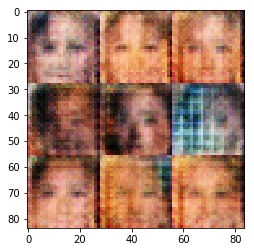

epoch: 1/1, discriminator loss: 0.11379770934581757, generator loss: 2.804734468460083
epoch: 1/1, discriminator loss: 0.035923320800065994, generator loss: 3.5336663722991943
epoch: 1/1, discriminator loss: 0.11941248923540115, generator loss: 2.6103031635284424
epoch: 1/1, discriminator loss: 0.09027324616909027, generator loss: 3.106363296508789
epoch: 1/1, discriminator loss: 0.5928581357002258, generator loss: 0.8387879729270935
epoch: 1/1, discriminator loss: 0.4727853536605835, generator loss: 1.1560043096542358
epoch: 1/1, discriminator loss: 0.4136398732662201, generator loss: 1.1444091796875


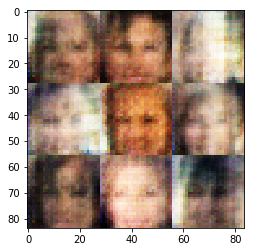

epoch: 1/1, discriminator loss: 0.19574980437755585, generator loss: 1.7509441375732422
epoch: 1/1, discriminator loss: 0.07878706604242325, generator loss: 2.639678716659546
epoch: 1/1, discriminator loss: 0.10617587715387344, generator loss: 2.4676754474639893
epoch: 1/1, discriminator loss: 0.06723921746015549, generator loss: 2.8563644886016846
epoch: 1/1, discriminator loss: 0.12114275991916656, generator loss: 2.315937042236328
epoch: 1/1, discriminator loss: 0.2813977003097534, generator loss: 1.4721736907958984


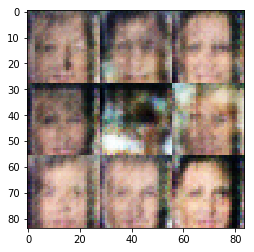

epoch: 1/1, discriminator loss: 0.11911959946155548, generator loss: 2.457362413406372
epoch: 1/1, discriminator loss: 0.016832638531923294, generator loss: 4.638761520385742
epoch: 1/1, discriminator loss: 0.07622337341308594, generator loss: 2.6711196899414062
epoch: 1/1, discriminator loss: 0.06937585771083832, generator loss: 2.808431625366211
epoch: 1/1, discriminator loss: 0.12919944524765015, generator loss: 2.3815786838531494


In [35]:
batch_size = 64
z_dim = 140
learning_rate = 0.0002
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.